<a href="https://colab.research.google.com/github/larasauser/2024_MLEES/blob/main/Project/project_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**# Machine learning Project - Sauser Lara**
## *Filling gaps in NDVI images using CNN*
The goal of this notebook is to build a CNN model with a simplified U-net architecture in order to fill gaps in NDVI images. Here are the steps I followed:


1.   Data processing


*   Loading the dataset
*   Imputing the images with the Median strategy
*   Split the images into smaller sub-images of 32x32 pixels
*   Add holes in the sub-images
*   Separate into train, validation and test set.
*   Pair the ground truth images with their respective hole version
*   Create X_train,y_train, X_val,y_val


2.   Model building


*   Create loss function
*   Build the architecture
*   Tune Hyperparameters
*   Train the model with the optimal parameters
*   Evaluate



3.   Test the performance on the test set


*   Load the images
*   Pair the ground truth images with their respective hole version
*   Load the model
*   Make predictions
*   Visualise the results
*   Evaluate the model (Distribution, R2, RMSE, MAE)

















### 0. Dependancies, drive mount

Please run these cells before going further.

In [2]:
# System-specific utilities
!apt-get install graphviz
!pip install rasterio
!pip install keras-tuner
# Dependencies
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow import keras

import tensorflow as tf
import keras_tuner as kt
from keras_tuner import HyperParameters

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, ListedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns

import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

from tqdm import tqdm
import rasterio

import random
import os
import shutil
import json
from google.colab import drive


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [3]:
#Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Data processing





First, let's get access to the image folder.

In [6]:
folder_path = '/content/drive/My Drive/NDVI_images/'

Let's visualise some of our original images to see what we are working with.

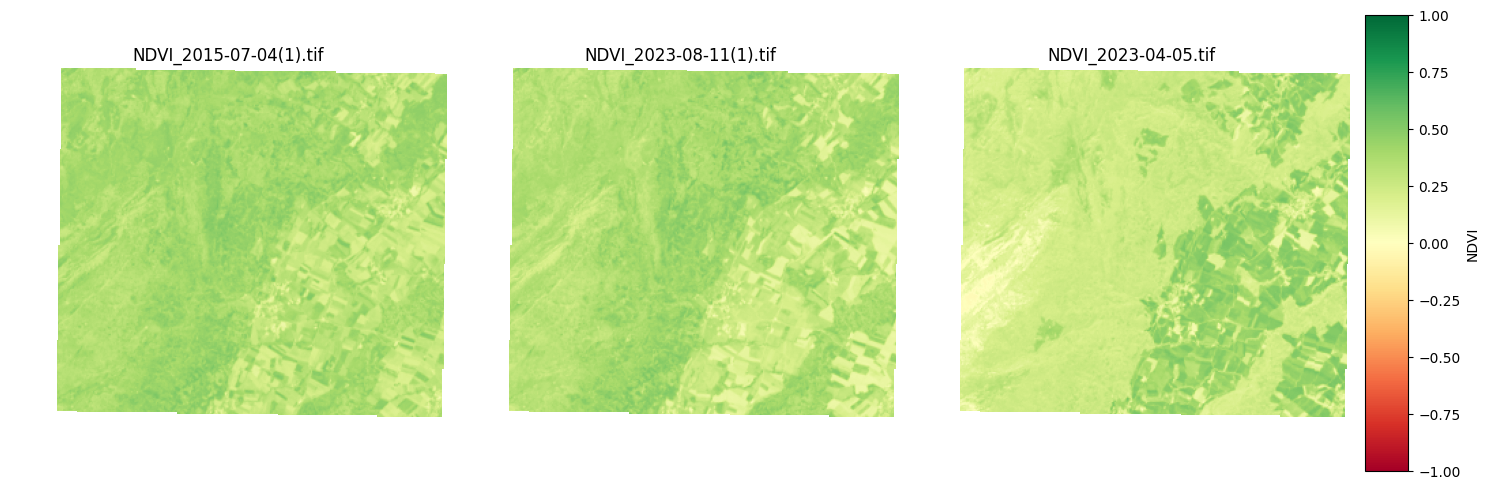

In [7]:
# Get a list of files in the directory
tif_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]

# Indexes to visualise
selected_indices = [10, 45, 90 ]

# Ensure indices are within range
selected_files = [tif_files[i] for i in selected_indices if i < len(tif_files)]

# Set up layout
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, len(selected_files) + 1, width_ratios=[1] * len(selected_files) + [0.1])  # Extra column for the colorbar

axes = [fig.add_subplot(gs[0, i]) for i in range(len(selected_files))]  # Subplots for images
cbar_ax = fig.add_subplot(gs[0, -1])  # Separate subplot for the colorbar

for i, file_name in enumerate(selected_files):
    file_path = os.path.join(folder_path, file_name)

    # Open the GeoTIFF file
    with rasterio.open(file_path) as src:
        ndvi_data = src.read(1)  # Read the first band (NDVI values)
        ndvi_data = np.where(ndvi_data == src.nodata, np.nan, ndvi_data)  # Handle NaN values

    # Plot the NDVI data in the subplot
    im = axes[i].imshow(ndvi_data, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[i].set_title(file_name)
    axes[i].axis('off')

# Add the shared colorbar in the dedicated axis
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('NDVI')

# Adjust layout
plt.tight_layout()
plt.show()

Images contains NaNs values. Thus, we need to fill them in.
We use a SimpleImputer based on the median strategy.

In [ ]:
# Create folder with imputed images
output_folder = os.path.join(folder_path, "imputed")
os.makedirs(output_folder, exist_ok=True)

# Imputation function
def impute_ndvi_image(image_path, output_path):
    with rasterio.open(image_path) as src:
        image = src.read(1)
        meta = src.meta

    # Mask NaN
    nan_mask = np.isnan(image)

    # Imputation of NaN with median
    imputer = SimpleImputer(strategy='median')
    image_imputed = imputer.fit_transform(image)

    # Save the image
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(image_imputed, 1)

# Loop over every file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):
        input_path = os.path.join(folder_path, filename)
        output_path = os.path.join(output_folder, filename)
        impute_ndvi_image(input_path, output_path)


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]. At least one non-missing value is needed fo

The next chunk is used to verify that the images were correctly imputed and that no NaN remains.

In [8]:
folder_path = '/content/drive/My Drive/NDVI_images/imputed'

def check_for_nan(image_path):
    with rasterio.open(image_path) as src:
        image = src.read(1)
    if np.isnan(image).any():
        print(f"Il reste des NaN dans {image_path}")
    else:
        print(f"Pas de NaN dans {image_path}")

for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):
        file_path = os.path.join(folder_path, filename)
        check_for_nan(file_path)


Pas de NaN dans /content/drive/My Drive/NDVI_images/imputed/NDVI_2013-12-30.tif
Pas de NaN dans /content/drive/My Drive/NDVI_images/imputed/NDVI_2014-03-20.tif
Pas de NaN dans /content/drive/My Drive/NDVI_images/imputed/NDVI_2015-04-24.tif
Pas de NaN dans /content/drive/My Drive/NDVI_images/imputed/NDVI_2015-05-10.tif
Pas de NaN dans /content/drive/My Drive/NDVI_images/imputed/NDVI_2020-05-07.tif
Pas de NaN dans /content/drive/My Drive/NDVI_images/imputed/NDVI_2013-07-14(1).tif
Pas de NaN dans /content/drive/My Drive/NDVI_images/imputed/NDVI_2013-08-15(1).tif
Pas de NaN dans /content/drive/My Drive/NDVI_images/imputed/NDVI_2014-07-17(1).tif
Pas de NaN dans /content/drive/My Drive/NDVI_images/imputed/NDVI_2014-07-01.tif
Pas de NaN dans /content/drive/My Drive/NDVI_images/imputed/NDVI_2015-04-15.tif
Pas de NaN dans /content/drive/My Drive/NDVI_images/imputed/NDVI_2015-07-04(1).tif
Pas de NaN dans /content/drive/My Drive/NDVI_images/imputed/NDVI_2015-08-21(1).tif
Pas de NaN dans /content/

To have more images and to reduce computational cost, we decide to devide them into sub-images of 32x32 pixels.

In [ ]:
def split_image(image_path, output_folder, sub_image_size=(32, 32)):
    # Open image
    img = Image.open(image_path)
    img_width, img_height = img.size

    # Image count
    count = 0

    # Division
    for i in range(0, img_width, sub_image_size[0]):
        for j in range(0, img_height, sub_image_size[1]):
            # Cutting box
            box = (i, j, i + sub_image_size[0], j + sub_image_size[1])
            # Cutting
            sub_image = img.crop(box)
            # Verification (size)
            if sub_image.size[0] > 0 and sub_image.size[1] > 0:
                # Saving
                sub_image.save(os.path.join(output_folder, f"{os.path.splitext(os.path.basename(image_path))[0]}_sub_image_{count}.tif"))
                count += 1
    print(count)

def process_all_images(input_folder, output_folder):
    # List all tif file in input folder
    for filename in os.listdir(input_folder):
        if filename.endswith('.tif'):
            image_path = os.path.join(input_folder, filename)
            print(f"Image in treatment : {filename}")
            split_image(image_path, output_folder)


In [ ]:
#Split our images
folder_path = '/content/drive/My Drive/NDVI_images/imputed'
output_folder = '/content/drive/My Drive/NDVI_images/split'
process_all_images(folder_path, output_folder)

Image in treatment : NDVI_2013-12-30.tif
88
Image in treatment : NDVI_2014-03-20.tif
88
Image in treatment : NDVI_2015-04-24.tif
88
Image in treatment : NDVI_2015-05-10.tif
88
Image in treatment : NDVI_2020-05-07.tif
88
Image in treatment : NDVI_2013-07-14(1).tif
88
Image in treatment : NDVI_2013-08-15(1).tif
88
Image in treatment : NDVI_2014-07-17(1).tif
88
Image in treatment : NDVI_2014-07-01.tif
88
Image in treatment : NDVI_2015-04-15.tif
88
Image in treatment : NDVI_2015-07-04(1).tif
88
Image in treatment : NDVI_2015-08-21(1).tif
88
Image in treatment : NDVI_2015-08-05(1).tif
88
Image in treatment : NDVI_2016-08-23(1).tif
88
Image in treatment : NDVI_2016-08-07(1).tif
88
Image in treatment : NDVI_2016-09-08(1).tif
88
Image in treatment : NDVI_2016-09-24(1).tif
88
Image in treatment : NDVI_2017-04-20(1).tif
88
Image in treatment : NDVI_2017-02-15.tif
88
Image in treatment : NDVI_2017-05-22(1).tif
88
Image in treatment : NDVI_2017-08-26(1).tif
88
Image in treatment : NDVI_2017-10-13(

We now have 8184 images to use for our model.

#### 1.1 Split the dataset into train, validation and test set

In [ ]:
# Define the source directory and the new directories for train, validation, and test sets
source_dir = '/content/drive/My Drive/NDVI_images/split'
train_dir = '/content/drive/My Drive/NDVI_images/train'
val_dir = '/content/drive/My Drive/NDVI_images/validation'
test_dir = '/content/drive/My Drive/NDVI_images/test'

In [ ]:
# Create the new directories if they don't exist
for dir in [train_dir, val_dir, test_dir]:
    if not os.path.exists(dir):
        os.makedirs(dir)

In [ ]:
# Get all image files from the source directory
all_images = [f for f in os.listdir(source_dir) if f.endswith(('.tif'))]

In [ ]:
# Shuffle the list of images
random.shuffle(all_images)

In [ ]:
# Calculate the number of images for each set
total_images = len(all_images)
train_split = int(0.7 * total_images)
val_split = int(0.2 * total_images)

In [ ]:
# Split the images into train, validation, and test sets
train_images = all_images[:train_split]
val_images = all_images[train_split:train_split+val_split]
test_images = all_images[train_split+val_split:]

In [ ]:
# Function to copy images to their respective directories
def copy_images(image_list, destination):
    for image in image_list:
        src = os.path.join(source_dir, image)
        dst = os.path.join(destination, image)
        shutil.copy(src, dst)


In [ ]:
# Copy the images to their respective directories
copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

In [ ]:
print(f"Total images: {total_images}")
print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")
print(f"Test images: {len(test_images)}")

Total images: 8184
Training images: 5728
Validation images: 1636
Test images: 820


#### 1.2 Create fake holes in images for training set

We decided to simulate missing data by adding holes in the images by deleting pixels (replacing values with NaNs). Images will contains 4 holes randomly placed of a random size between 1 and 12 pixels wide. In order to keep the original images as ground truth, copy of the files are done before adding holes to them. To make pairing easier later, same file name are kept, but they are placed in a dedicated folder.

In [ ]:
# Define the paths
train_dir = '/content/drive/My Drive/NDVI_images/train'
output_dir = os.path.join(train_dir, 'train_with_holes')

In [ ]:
def add_fake_holes(image, num_holes=4, max_hole_size=12):
    image_with_holes = image.copy()
    height, width = image.shape[:2]

    for _ in range(num_holes):
        # Randomly select a center for the hole
        x_center = np.random.randint(0, width)
        y_center = np.random.randint(0, height)

        # Randomly determine the size of the hole
        hole_width = np.random.randint(1, max_hole_size)
        hole_height = np.random.randint(1, max_hole_size)

        # Create the hole (set pixel values to nan)
        x_start = max(0, x_center - hole_width // 2)
        x_end = min(width, x_center + hole_width // 2)
        y_start = max(0, y_center - hole_height // 2)
        y_end = min(height, y_center + hole_height // 2)

        image_with_holes[y_start:y_end, x_start:x_end] = np.nan

    return image_with_holes


In [43]:
def process_and_add_fake_holes(train_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate over all images in the train_dir
    for filename in os.listdir(train_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(train_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                # Load the image using rasterio
                with rasterio.open(input_path) as src:
                    image = src.read(1)  # Read the first band
                    meta = src.meta.copy()  # Copy metadata

                # Add fake holes
                image_with_holes = add_fake_holes(image)

                # Update the metadata (e.g., for nodata values)
                meta.update(dtype='float32', nodata=np.nan)

                # Save the processed image
                with rasterio.open(output_path, 'w', **meta) as dst:
                    dst.write(image_with_holes, 1)  # Write to the first band
            except Exception as e:
                print(f"Failed to process {filename}: {e}")


In [ ]:
process_and_add_fake_holes(train_dir, output_dir)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


#### 1.3 Create holes in image of the validation set

The same step are repeated for the validation set.

In [9]:
# Define the paths
val_dir = '/content/drive/My Drive/NDVI_images/validation'
output_dir = os.path.join(val_dir, 'val_with_holes')

In [ ]:
# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

In [ ]:
def add_fake_holes(image, num_holes=4, max_hole_size=12):
    image_with_holes = image.copy()
    height, width = image.shape[:2]

    for _ in range(num_holes):
        # Randomly select a center for the hole
        x_center = np.random.randint(0, width)
        y_center = np.random.randint(0, height)

        # Randomly determine the size of the hole
        hole_width = np.random.randint(1, max_hole_size)
        hole_height = np.random.randint(1, max_hole_size)

        # Create the hole (set pixel values to nan)
        x_start = max(0, x_center - hole_width // 2)
        x_end = min(width, x_center + hole_width // 2)
        y_start = max(0, y_center - hole_height // 2)
        y_end = min(height, y_center + hole_height // 2)

        image_with_holes[y_start:y_end, x_start:x_end] = np.nan

    return image_with_holes


In [64]:
def process_and_add_fake_holes(val_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate over all images in the train_dir
    for filename in os.listdir(val_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(val_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                # Load the image using rasterio
                with rasterio.open(input_path) as src:
                    image = src.read(1)  # Read the first band
                    meta = src.meta.copy()  # Copy metadata

                # Add fake holes
                image_with_holes = add_fake_holes(image)

                # Update the metadata (e.g., for nodata values)
                meta.update(dtype='float32', nodata=np.nan)

                # Save the processed image
                with rasterio.open(output_path, 'w', **meta) as dst:
                    dst.write(image_with_holes, 1)  # Write to the first band
            except Exception as e:
                print(f"Failed to process {filename}: {e}")


In [ ]:
process_and_add_fake_holes(val_dir, output_dir)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


We can now see with the code below how our images look before continuing.

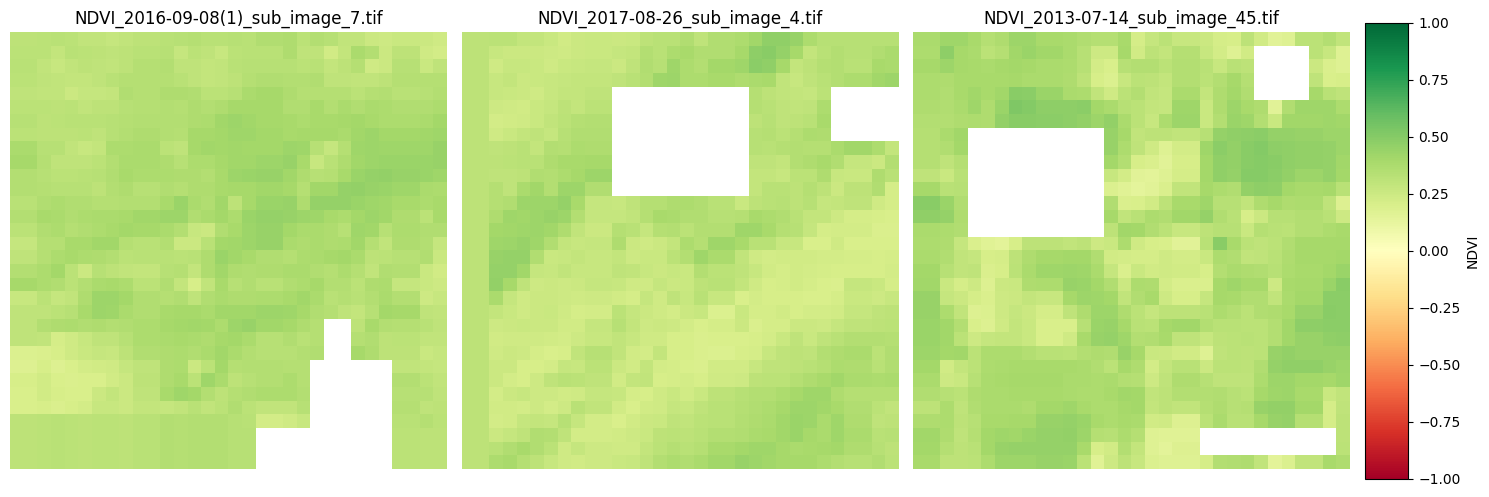

In [ ]:
# Get a list of files in the directory
tif_files = [f for f in os.listdir(train_with_holes_dir) if f.endswith('.tif')]

# Indexes
selected_indices = [0, 50, 1000 ]

# Ensure indices are within range
selected_files = [tif_files[i] for i in selected_indices if i < len(tif_files)]

# Set up layout
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, len(selected_files) + 1, width_ratios=[1] * len(selected_files) + [0.1])  # Extra column for the colorbar

axes = [fig.add_subplot(gs[0, i]) for i in range(len(selected_files))]  # Subplots for images
cbar_ax = fig.add_subplot(gs[0, -1])  # Separate subplot for the colorbar

for i, file_name in enumerate(selected_files):
    file_path = os.path.join(train_with_holes_dir, file_name)

    # Open the GeoTIFF file
    with rasterio.open(file_path) as src:
        ndvi_data = src.read(1)  # Read the first band (NDVI values)
        ndvi_data = np.where(ndvi_data == src.nodata, np.nan, ndvi_data)  # Handle NoData values

    # Plot the NDVI data in the subplot
    im = axes[i].imshow(ndvi_data, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[i].set_title(file_name)
    axes[i].axis('off')

# Add the shared colorbar in the dedicated axis
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('NDVI')

# Adjust layout
plt.tight_layout()
plt.show()

Great ! We can see that random holes are effectively introduced into the images. We can proceed.

#### 1.4 Pairing the complete images with the images with holes (train and validation)

Images are paired via file names.

In [4]:
#Load the training data
train_dir = '/content/drive/My Drive/NDVI_images/train'
train_with_holes_dir = '/content/drive/My Drive/NDVI_images/train/train_with_holes'

val_dir = '/content/drive/My Drive/NDVI_images/validation'
val_with_holes_dir = '/content/drive/My Drive/NDVI_images/validation/val_with_holes'

In [5]:
def load_and_pair_images(input_dir, target_dir):
    image_pairs = []
    for filename in os.listdir(input_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(input_dir, filename)
            target_path = os.path.join(target_dir, filename)

            # Load images
            input_img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
            target_img = cv2.imread(target_path, cv2.IMREAD_UNCHANGED)

            if input_img is not None and target_img is not None:
                image_pairs.append((input_img, target_img))
            else:
                print(f"Failed to load {filename}. Skipping...")
    return image_pairs

In [6]:
# Load and pair the training data
train_data = load_and_pair_images(train_dir, train_with_holes_dir)

# Load and pair validation data
val_data = load_and_pair_images(val_dir, val_with_holes_dir)

#### 1.5 Masking

For the code to work, the images can't have NaNs values. But we just introduced some. Therefore, we want to change that. We want a value outside of the range of NDVI values so that they won't interfere. We chose a value of 10.

In [7]:
MASK_VALUE = 10  # Set a value to replace NaN

In [8]:
# Convert to numpy arrays
X_train = np.array([pair[0] for pair in train_data])
y_train = np.array([pair[1] for pair in train_data])

In [9]:
X_val = np.array([pair[0] for pair in val_data])
y_val = np.array([pair[1] for pair in val_data])

In [10]:
# Replace NaN with MASK_VALUE in training and validation datasets
X_train = np.nan_to_num(X_train, nan=MASK_VALUE)
y_train = np.nan_to_num(y_train, nan=MASK_VALUE)

X_val = np.nan_to_num(X_val, nan=MASK_VALUE)
y_val = np.nan_to_num(y_val, nan=MASK_VALUE)

In [11]:
print("X_train min, max:", np.min(X_train), np.max(X_train))
print("y_train min, max:", np.min(y_train), np.max(y_train))
print("X_val min, max:", np.min(X_val), np.max(X_val))
print("y_val min, max:", np.min(y_val), np.max(y_val))

X_train min, max: -0.12699474 0.9998047
y_train min, max: -0.12699474 10.0
X_val min, max: -0.1493801 0.9994043
y_val min, max: -0.1493801 10.0


We can see that the ranges in the original images are within -1 and 1. The image with holes goes up to 10, because of the Mask value.

### 2. Model Building (CNN)

#### 2.1 Loss function

Because of the mask_value, we need to change the way the loss function is calculated, to avoid the value 10. Here is the new loss function.

In [12]:
# Define the custom loss function
def masked_mae(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, MASK_VALUE), tf.float32)
    loss = tf.reduce_sum(mask * tf.abs(y_true - y_pred)) / tf.reduce_sum(mask)
    return loss

#### 2.4 Building the CNN

The goal is to build a simple CNN with a U-Net architecture that is able to produce output between -1 and 1. To do so, we need a Encoder, a decoder and a skip connexion in between. The activation functions will be ReLU for its efficiency and Tanh in the output layer to retrieve the -1 to 1 range.
To mitigate potential overfitting, we added dropout layers.

In [13]:
def build_unet_model(input_shape):
    """Build a simple U-Net model."""
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = layers.Dropout(0.2)(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    # Bottleneck
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = layers.Dropout(0.3)(conv2)

    # Decoder
    up3 = layers.UpSampling2D((2, 2))(conv2)
    concat3 = layers.Concatenate()([up3, conv1])
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat3)
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)

    # Output layer
    output = layers.Conv2D(1, (1, 1), activation='tanh', padding='same')(conv3)

    # Compile model
    model = models.Model(inputs, output)
    model.compile(optimizer='adam', loss=masked_mae, metrics=['mae'])

    return model

#### 2.5 Hyperparameter optimization

We decided to optimize the learning rate using randomsearch from Keras Tuner

In [20]:
def model_builder(hp):
    model = build_unet_model((32, 32, 1))

    # Tune the learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
    ), loss=masked_mae, metrics=['mae'])

    return model

In [21]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=10,  # Limit to 10 trials for computational cost
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='ndvi_inpainting',
)

In [22]:
# Perform Hyperparameter Search
tuner.search(X_train, y_train, epochs=4, validation_data=(X_val, y_val),
            batch_size=32)

Trial 10 Complete [00h 20m 38s]
val_loss: 0.013730124570429325

Best val_loss So Far: 0.002393252681940794
Total elapsed time: 03h 10m 29s


In [23]:
# Get the best Hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best learning rate: ", best_hp['learning_rate'])

Best learning rate:  0.0009120605909040556


In [24]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Save the hyperparameters to a JSON file
hyperparameters_path = '/content/drive/My Drive/NDVI_images/best_hyperparameters_3.json'

with open(hyperparameters_path, 'w') as f:
    json.dump(best_hp.values, f, indent=4)

print(f"Best hyperparameters saved to {hyperparameters_path}")


Best hyperparameters saved to /content/drive/My Drive/NDVI_images/best_hyperparameters_3.json


#### 2.6 Train the model with the best Hyperparameters

In [14]:
hyperparameters_path = '/content/drive/My Drive/NDVI_images/best_hyperparameters_3.json'
# Load the hyperparameters from the JSON file
with open(hyperparameters_path, 'r') as f:
    loaded_hyperparameters = json.load(f)

print("Loaded hyperparameters:", loaded_hyperparameters)

Loaded hyperparameters: {'learning_rate': 0.0009120605909040556}


In [15]:
# Rebuild the U-Net model
input_shape = (32, 32, 1)  # Adjust as per your dataset
best_model = build_unet_model(input_shape)

# Compile the model with the loaded learning rate
best_model.compile(
    optimizer=Adam(learning_rate=loaded_hyperparameters['learning_rate']),
    loss=masked_mae,
    metrics=['mae']
)

In [22]:
# Configure EarlyStopping to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [23]:
# Set up callbacks to monitor progress
history = best_model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), batch_size=32,callbacks=[early_stopping])


Epoch 1/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - loss: 0.0075 - mae: 0.9711 - val_loss: 0.0020 - val_mae: 0.9688
Epoch 2/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - loss: 0.0053 - mae: 0.9678 - val_loss: 0.0023 - val_mae: 0.9689
Epoch 3/25
118/179 ━━━━━━━━━━━━━━━━━━━━ 1:23 1s/step - loss: 0.0055 - mae: 0.9652

KeyboardInterrupt: 

In [19]:
# Save the model
best_model.save('/content/drive/My Drive/NDVI_images/best_unet_model_3.keras')

#### 2.7 Evaluation of Loss and MAE

In [20]:
def plot_history(history, save_path):
    """Plot loss and MAE over epochs and save the plots."""
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot MAE (Mean Absolute Error)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Mean Absolute Error (MAE)')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    # Save the plots to file
    plt.savefig(save_path)
    plt.close()

In [21]:
plot_history(history, '/content/drive/My Drive/NDVI_images/training_history_3.png')

### 3. Verification on the Test set

##### 2.5.1 Create fake holes in images for test set

In [24]:
# Define the paths
test_dir = '/content/drive/My Drive/NDVI_images/test'
output_dir = os.path.join(test_dir, 'test_with_holes')

In [25]:
# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

In [27]:
def add_fake_holes(image, num_holes=4, max_hole_size=12):
    image_with_holes = image.copy()
    height, width = image.shape[:2]

    for _ in range(num_holes):
        # Randomly select a center for the hole
        x_center = np.random.randint(0, width)
        y_center = np.random.randint(0, height)

        # Randomly determine the size of the hole
        hole_width = np.random.randint(1, max_hole_size)
        hole_height = np.random.randint(1, max_hole_size)

        # Create the hole (set pixel values to zero)
        x_start = max(0, x_center - hole_width // 2)
        x_end = min(width, x_center + hole_width // 2)
        y_start = max(0, y_center - hole_height // 2)
        y_end = min(height, y_center + hole_height // 2)

        image_with_holes[y_start:y_end, x_start:x_end] = np.nan  # Simulate cloud (masked area)

    return image_with_holes


In [28]:
def process_and_add_fake_holes(test_dir, output_dir):
    """
    Iterate over all GeoTIFF images in a directory, add fake holes, and save the processed images.
    Args:
        train_dir (str): Directory containing input GeoTIFF images.
        output_dir (str): Directory to save processed GeoTIFF images.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate over all images in the train_dir
    for filename in os.listdir(test_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(test_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                # Load the image using rasterio
                with rasterio.open(input_path) as src:
                    image = src.read(1)  # Read the first band
                    meta = src.meta.copy()  # Copy metadata

                # Add fake holes
                image_with_holes = add_fake_holes(image)

                # Update the metadata (e.g., for nodata values)
                meta.update(dtype='float32', nodata=np.nan)

                # Save the processed image
                with rasterio.open(output_path, 'w', **meta) as dst:
                    dst.write(image_with_holes, 1)  # Write to the first band

                #print(f"Processed and saved: {output_path}")

            except Exception as e:
                print(f"Failed to process {filename}: {e}")


In [ ]:
process_and_add_fake_holes(test_dir, output_dir)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


In [29]:
#Load the test data
test_dir = '/content/drive/My Drive/NDVI_images/test'
test_with_holes_dir = '/content/drive/My Drive/NDVI_images/test/test_with_holes'

##### 2.5.2 Pairing the complete images with the images with holes (test)

In [30]:
def load_and_pair_images(input_dir, target_dir):
    """Load original images and images with holes, and pair them."""
    image_pairs = []
    for filename in os.listdir(input_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(input_dir, filename)
            target_path = os.path.join(target_dir, filename)

            # Load images
            input_img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
            target_img = cv2.imread(target_path, cv2.IMREAD_UNCHANGED)

            if input_img is not None and target_img is not None:
                image_pairs.append((input_img, target_img))
            else:
                print(f"Failed to load {filename}. Skipping...")
    return image_pairs

In [31]:
# Load and pair the training data
test_data = load_and_pair_images(test_dir, test_with_holes_dir)

##### 2.5.3 Data processing and masking

In [32]:
MASK_VALUE = 10  # Set a value to replace NaN

In [33]:
# Convert to numpy arrays
X_test = np.array([pair[0] for pair in test_data])
y_test = np.array([pair[1] for pair in test_data])

In [34]:
# Replace NaN with MASK_VALUE in training and validation datasets
X_test = np.nan_to_num(X_test, nan=MASK_VALUE)
y_test = np.nan_to_num(y_test, nan=MASK_VALUE)

In [35]:
print("X_test min, max:", np.min(X_test), np.max(X_test))
print("y_test min, max:", np.min(y_test), np.max(y_test))

X_test min, max: -0.09456226 0.9920558
y_test min, max: -0.09456226 10.0


In [36]:
# Define the custom loss function
def masked_mae(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, MASK_VALUE), tf.float32)
    loss = tf.reduce_sum(mask * tf.abs(y_true - y_pred)) / tf.reduce_sum(mask)
    return loss

##### 2.5.4 Apply CNN

In [38]:
from tensorflow.keras.models import load_model

In [39]:
# Load the saved model
model_path = '/content/drive/My Drive/NDVI_images/best_unet_model_3.keras'
best_model = load_model(model_path, custom_objects={'masked_mae': masked_mae})

In [40]:
# Evaluate the model
test_loss, test_mae = best_model.evaluate(X_test, y_test, batch_size=32)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 440ms/step - loss: 0.0020 - mae: 0.9464
Test Loss: 0.002018166473135352
Test MAE: 0.9533507823944092


In [41]:
# Generate predictions
y_pred = best_model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 331ms/step


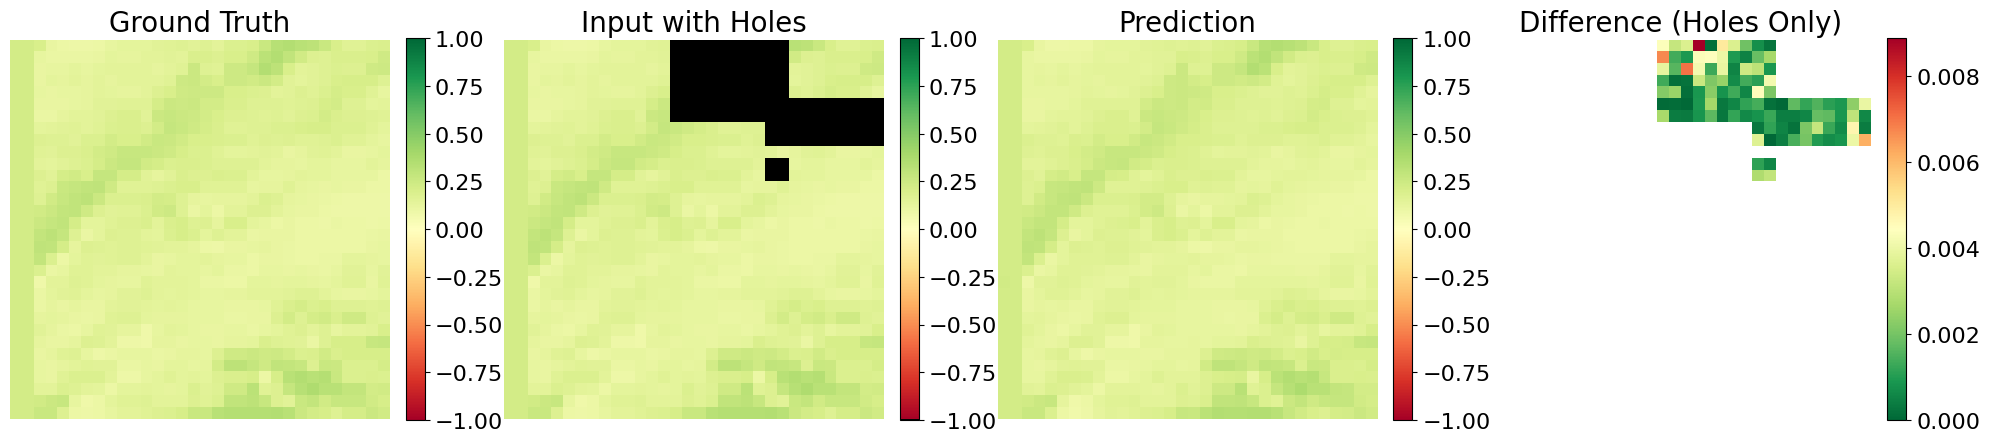

In [42]:
# Création d'une colormap personnalisée pour les trous (valeurs spéciales = 10)
cmap = plt.cm.RdYlGn  # Colormap de base
cmap_colors = cmap(np.linspace(0, 1, 256))
cmap_colors[0] = [0, 0, 0, 1]  # Noir pour les trous (valeurs à 10)
custom_cmap = ListedColormap(cmap_colors)

# Normalisation personnalisée
class CustomNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, special_value=None, **kwargs):
        super().__init__(vmin=vmin, vmax=vmax, **kwargs)
        self.special_value = special_value

    def __call__(self, value, clip=None):
        # Traite les trous comme une valeur spéciale
        result = super().__call__(value, clip)
        result = np.ma.masked_where(value == self.special_value, result)
        result = np.ma.filled(result, 0)  # Mappe les trous (valeurs à 10) sur la première couleur (noir)
        return result

# Appliquer la normalisation personnalisée pour gérer les trous
norm = CustomNormalize(vmin=-1, vmax=1, special_value=10)

# Calcul de la différence entre l'image prédite et l'image originale
difference = np.abs(X_test - y_pred.squeeze())  # Différence absolue

# Créer un masque pour afficher uniquement les trous
mask_holes = (y_test == 10)  # Masque des pixels troués
difference_holes_only = np.where(mask_holes, difference, np.nan)  # Masque les autres pixels

# Visualisation des résultats
idx = 555  # Index pour visualiser un échantillon spécifique

plt.figure(figsize=(20, 5))

# Vérité terrain
plt.subplot(1, 4, 1)
plt.title("Ground Truth", fontsize=20)  # Increase font size
img1 = plt.imshow(X_test[idx, :, :], cmap='RdYlGn', norm=norm)
plt.axis('off')
cbar1 = plt.colorbar(img1, fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=16)  # Increase colorbar font size

# Image d'entrée avec trous
plt.subplot(1, 4, 2)
plt.title("Input with Holes", fontsize=20)  # Increase font size
img2 = plt.imshow(y_test[idx, :, :], cmap=custom_cmap, norm=norm)
plt.axis('off')
cbar2 = plt.colorbar(img2, fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=16)  # Increase colorbar font size

# Prédictions
plt.subplot(1, 4, 3)
plt.title("Prediction", fontsize=20)  # Increase font size
img3 = plt.imshow(y_pred[idx, :, :], cmap='RdYlGn', norm=norm)
plt.axis('off')
cbar3 = plt.colorbar(img3, fraction=0.046, pad=0.04)
cbar3.ax.tick_params(labelsize=16)  # Increase colorbar font size

# Différence uniquement dans les trous
plt.subplot(1, 4, 4)
plt.title("Difference (Holes Only)", fontsize=20)  # Increase font size
img4 = plt.imshow(difference_holes_only[idx, :, :], cmap='RdYlGn_r', vmin=0)  # Colormap pour différences
plt.axis('off')
cbar4 = plt.colorbar(img4, fraction=0.046, pad=0.04)
cbar4.ax.tick_params(labelsize=16)  # Increase colorbar font size

plt.tight_layout()
plt.show()


##### 2.5.5 Evaluate the model

In [43]:
# Example: Assuming `MASK_VALUE` is the value used for invalid pixels
MASK_VALUE = 10  # Replace with your actual mask value

# Flatten the arrays to simplify processing (if needed)
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Step 1: Create a mask for valid pixels
valid_mask = y_test_flat != MASK_VALUE

# Step 2: Extract valid pixels from ground truth and predictions
y_test_valid = y_test_flat[valid_mask]
y_pred_valid = y_pred_flat[valid_mask]

# Step 3: Evaluate the model using the valid pixels
# Example: Calculate RMSE
rmse = np.sqrt(np.mean((y_test_valid - y_pred_valid) ** 2))
print(f"RMSE: {rmse}")

# Example: Calculate correlation coefficient (R²)
correlation = np.corrcoef(y_test_valid, y_pred_valid)[0, 1]
r_squared = correlation ** 2
print(f"R²: {r_squared}")



RMSE: 0.003193966578692198
R²: 0.9995675095566854


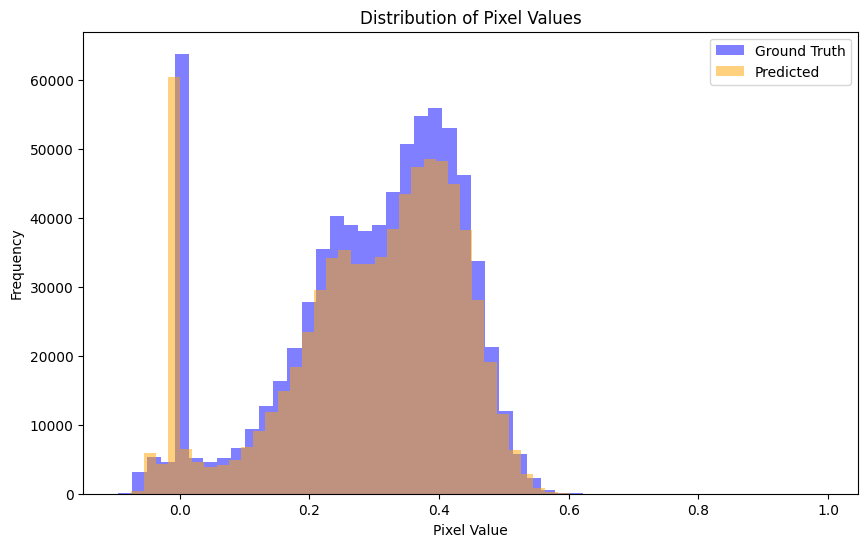

<ipython-input-44-09dce2b95e20>:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test_valid, label='Ground Truth', color='blue', shade=True)
<ipython-input-44-09dce2b95e20>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_valid, label='Predicted', color='orange', shade=True)


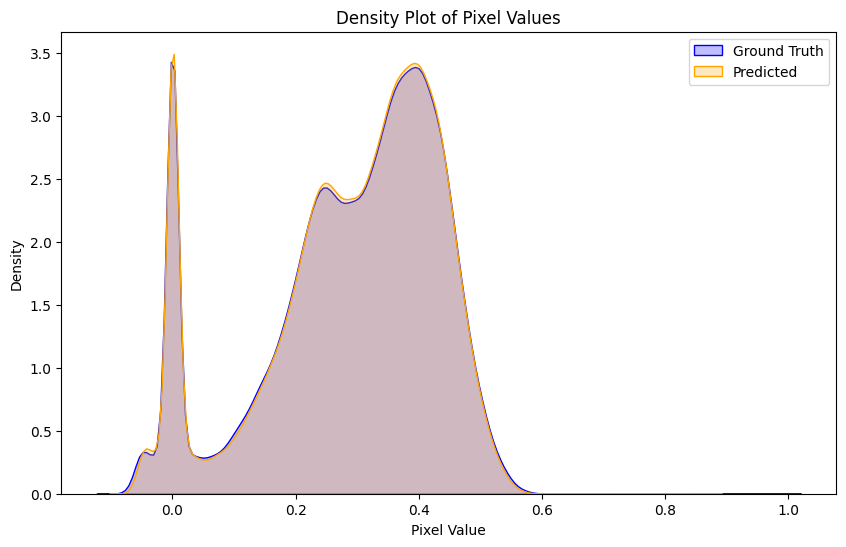

In [44]:
# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(y_test_valid, bins=50, alpha=0.5, label='Ground Truth', color='blue')
plt.hist(y_pred_valid, bins=50, alpha=0.5, label='Predicted', color='orange')
plt.title('Distribution of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Optional: Density plot (smoother)
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test_valid, label='Ground Truth', color='blue', shade=True)
sns.kdeplot(y_pred_valid, label='Predicted', color='orange', shade=True)
plt.title('Density Plot of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.legend()
plt.show()


In [45]:
mae = np.mean(np.abs(y_test_valid - y_pred_valid))
print(f"Mean Absolute Error (MAE): {mae}")
rmse = np.sqrt(np.mean((y_test_valid - y_pred_valid) ** 2))
print(f"Root Mean Square Error (RMSE): {rmse}")
mape = np.mean(np.abs((y_test_valid - y_pred_valid) / y_test_valid)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
correlation = np.corrcoef(y_test_valid, y_pred_valid)[0, 1]
r_squared = correlation ** 2
print(f"R² (Coefficient of Determination): {r_squared}")


Mean Absolute Error (MAE): 0.0020171627402305603
Root Mean Square Error (RMSE): 0.003193966578692198
Mean Absolute Percentage Error (MAPE): inf%
R² (Coefficient of Determination): 0.9995675095566854


<ipython-input-45-f0cdbcfc372e>:5: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test_valid - y_pred_valid) / y_test_valid)) * 100


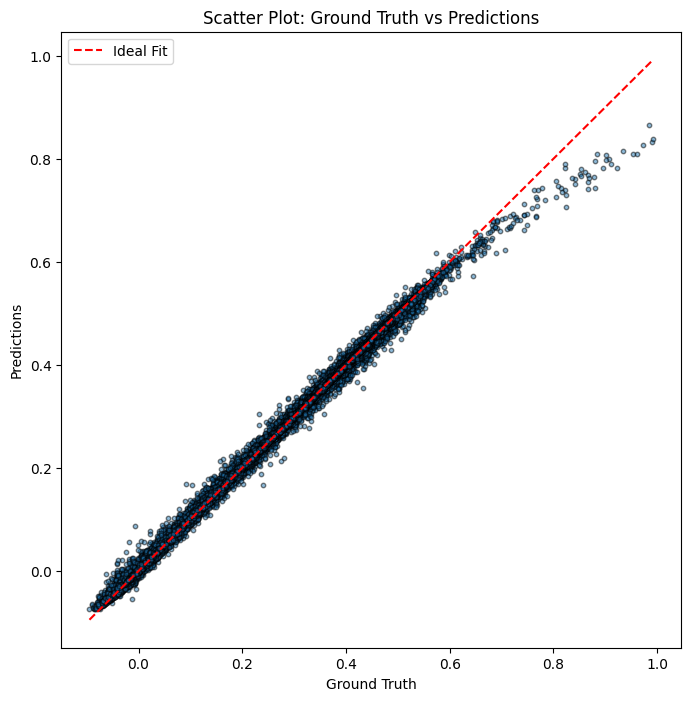

In [46]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test_valid, y_pred_valid, alpha=0.5, edgecolor='k', s=10)
plt.plot([y_test_valid.min(), y_test_valid.max()],
         [y_test_valid.min(), y_test_valid.max()],
         color='red', linestyle='--', label='Ideal Fit')
plt.title('Scatter Plot: Ground Truth vs Predictions')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.legend()
plt.show()


#### 3. Build the complex U-Net model

In [ ]:
#Load the training data
train_dir = '/content/drive/My Drive/NDVI_images/train'
train_with_holes_dir = '/content/drive/My Drive/NDVI_images/train/train_with_holes'

val_dir = '/content/drive/My Drive/NDVI_images/validation'
val_with_holes_dir = '/content/drive/My Drive/NDVI_images/validation/val_with_holes'

In [ ]:
#Dependencies
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
!pip install rasterio
import rasterio
import os
import cv2
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from PIL import Image

##### 2.0 Pairing the complete images with the images with holes (train and validation)

In [8]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
!pip install keras-tuner
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00


In [9]:
def load_and_pair_images(input_dir, target_dir):
    """Load original images and images with holes, and pair them."""
    image_pairs = []
    for filename in os.listdir(input_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(input_dir, filename)
            target_path = os.path.join(target_dir, filename)

            # Load images
            input_img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
            target_img = cv2.imread(target_path, cv2.IMREAD_UNCHANGED)

            if input_img is not None and target_img is not None:
                image_pairs.append((input_img, target_img))
            else:
                print(f"Failed to load {filename}. Skipping...")
    return image_pairs

In [11]:
# Load and pair the training data
train_data = load_and_pair_images(train_dir, train_with_holes_dir)

# Load and pair validation images with holes
val_data = load_and_pair_images(val_dir, val_with_holes_dir)

##### 3.1 Data processing and masking

In [6]:
MASK_VALUE = 10  # Set a value to replace NaN

In [13]:
# Convert to numpy arrays
X_train = np.array([pair[0] for pair in train_data])
y_train = np.array([pair[1] for pair in train_data])

In [14]:
X_val = np.array([pair[0] for pair in val_data])
y_val = np.array([pair[1] for pair in val_data])

In [15]:
# Replace NaN with MASK_VALUE in training and validation datasets
X_train = np.nan_to_num(X_train, nan=MASK_VALUE)
y_train = np.nan_to_num(y_train, nan=MASK_VALUE)

X_val = np.nan_to_num(X_val, nan=MASK_VALUE)
y_val = np.nan_to_num(y_val, nan=MASK_VALUE)


In [16]:
print("X_train min, max:", np.min(X_train), np.max(X_train))
print("y_train min, max:", np.min(y_train), np.max(y_train))
print("X_val min, max:", np.min(X_val), np.max(X_val))
print("y_val min, max:", np.min(y_val), np.max(y_val))

X_train min, max: -0.12699474 0.9998047
y_train min, max: -0.12699474 10.0
X_val min, max: -0.1493801 0.9994043
y_val min, max: -0.1493801 10.0


In [29]:
def masked_bce_loss(y_true, y_pred):
    # Ensure y_true has the same shape as y_pred
    mask = tf.cast(tf.not_equal(y_true, MASK_VALUE), tf.float32)
    y_pred_rescaled = (y_pred + 1.0) / 2.0
    y_true_rescaled = (y_true + 1.0) / 2.0
    bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    loss = mask * bce(y_true_rescaled, y_pred_rescaled)
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)


##### 3.2 Building the U-Net CNN Model for Image Inpainting

In [30]:
from tensorflow.keras import layers, models

In [31]:
# Define a U-Net model
def build_unet_model(input_shape):
    """Build a U-Net model"""
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Dropout(0.2)(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Dropout(0.2)(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Dropout(0.3)(conv3)

    # Decoder
    up4 = layers.UpSampling2D((2, 2))(conv3)
    concat4 = layers.Concatenate()([up4, conv2])
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)

    up5 = layers.UpSampling2D((2, 2))(conv4)
    concat5 = layers.Concatenate()([up5, conv1])
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)

    # Output Layer
    output = layers.Conv2D(1, (1, 1), activation='tanh', padding='same')(conv5)

    # Compile model
    model = models.Model(inputs, output)
    model.compile(optimizer='adam', loss=masked_bce_loss, metrics=['accuracy'])

    return model

##### 3.3 Hyperparameter optimization using Keras tuner

In [32]:
def model_builder(hp):
    """Build a U-Net model with hyperparameter tuning."""
    model = build_unet_model((32, 32, 1))

    # Tune the learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
    ), loss=masked_bce_loss, metrics=['accuracy'])

    return model

In [33]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=10,  # Limit to 10 trials
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='ndvi_inpainting',
)

Reloading Tuner from hyperparameter_tuning/ndvi_inpainting/tuner0.json


In [34]:
# Perform Hyperparameter Search
tuner.search(X_train, y_train, epochs=4, validation_data=(X_val, y_val),
            batch_size=32)


Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
0.0037125         |0.00010026        |learning_rate

Epoch 1/4
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.0431 - loss: -0.1655

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.InvalidArgumentError: Graph execution error:

Detected at node compile_loss/masked_bce_loss/mul defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-34-4bc344f025b0>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 234, in search

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 345, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 433, in evaluate

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 154, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 85, in test_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/trainer.py", line 359, in _compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/trainer.py", line 327, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/compile_utils.py", line 611, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/compile_utils.py", line 652, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/loss.py", line 60, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py", line 27, in call

  File "<ipython-input-29-57ce3b1c4470>", line 7, in masked_bce_loss

Incompatible shapes: [4,32,32] vs. [4,32]
	 [[{{node compile_loss/masked_bce_loss/mul}}]] [Op:__inference_one_step_on_iterator_61610]


In [ ]:
# Get the best Hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best learning rate: ", best_hp['learning_rate'])

Best learning rate:  0.0006130578503627999


In [ ]:
import json

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Save the hyperparameters to a JSON file
hyperparameters_path = '/content/drive/My Drive/NDVI_images/best_hyperparameters_2.json'

with open(hyperparameters_path, 'w') as f:
    json.dump(best_hp.values, f, indent=4)

print(f"Best hyperparameters saved to {hyperparameters_path}")


Best hyperparameters saved to /content/drive/My Drive/NDVI_images/best_hyperparameters_1.json


##### 2.4.5 Train the model with the best Hyperparameters

In [35]:
import json
hyperparameters_path = '/content/drive/My Drive/NDVI_images/best_hyperparameters_1.json'
# Load the hyperparameters from the JSON file
with open(hyperparameters_path, 'r') as f:
    loaded_hyperparameters = json.load(f)

print("Loaded hyperparameters:", loaded_hyperparameters)

Loaded hyperparameters: {'learning_rate': 0.0006130578503627999}


In [36]:
from tensorflow.keras.optimizers import Adam
# Rebuild the U-Net model
input_shape = (32, 32, 1)  # Adjust as per your dataset
best_model = build_unet_model(input_shape)

# Compile the model with the loaded learning rate
best_model.compile(
    optimizer=Adam(learning_rate=loaded_hyperparameters['learning_rate']),
    loss=masked_bce_loss,
    metrics=['accuracy']
)

In [37]:
from tensorflow.keras.callbacks import EarlyStopping
# Configure EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=3,               # Stop training if no improvement after 3 epochs
    restore_best_weights=True # Restore model weights from the best epoch
)

In [38]:
#best_model = tuner.hypermodel.build(best_hp)

# Set up callbacks to monitor progress
history = best_model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), batch_size=16,callbacks=[early_stopping])


Epoch 1/25


ValueError: Dimensions must be equal, but are 32 and 16 for '{{node compile_loss/masked_bce_loss/mul}} = Mul[T=DT_FLOAT](compile_loss/masked_bce_loss/Cast, compile_loss/masked_bce_loss/binary_crossentropy/Mean)' with input shapes: [16,32,32], [16,32].

In [ ]:
# Save the model
best_model.save('/content/drive/My Drive/NDVI_images/best_unet_model_1.keras')

#### 3. Test on another region (Val d'Hérens)

In [47]:
folder_path = '/content/drive/My Drive/NDVI_herens/'

In [ ]:
# Créer un dossier pour sauvegarder les images corrigées
output_folder = os.path.join(folder_path, "imputed")
os.makedirs(output_folder, exist_ok=True)

# Fonction pour imputer les valeurs NaN
def impute_ndvi_image(image_path, output_path):
    with rasterio.open(image_path) as src:
        image = src.read(1)  # Lecture de la première bande uniquement
        meta = src.meta  # Métadonnées pour sauvegarde

    # Masque des NaN
    nan_mask = np.isnan(image)

    # Imputation des NaN avec la médiane
    imputer = SimpleImputer(strategy='median')
    image_imputed = imputer.fit_transform(image)

    # Sauvegarde de l'image corrigée
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(image_imputed, 1)

# Parcourir toutes les images dans le dossier et appliquer l'imputation
for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):
        input_path = os.path.join(folder_path, filename)
        output_path = os.path.join(output_folder, filename)
        impute_ndvi_image(input_path, output_path)


KeyboardInterrupt: 

In [ ]:
folder_path = '/content/drive/My Drive/NDVI_herens/imputed'

def check_for_nan(image_path):
    with rasterio.open(image_path) as src:
        image = src.read(1)  # Lecture de la première bande

    # Vérifier s'il reste des NaN
    if np.isnan(image).any():
        print(f"Il reste des NaN dans {image_path}")
    else:
        print(f"Pas de NaN dans {image_path}")

# Parcourir toutes les images dans le dossier imputé
for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):
        file_path = os.path.join(folder_path, filename)
        check_for_nan(file_path)

Pas de NaN dans /content/drive/My Drive/NDVI_herens/imputed/NDVI_Val_Herens_2013-04-18.tif
Pas de NaN dans /content/drive/My Drive/NDVI_herens/imputed/NDVI_Val_Herens_2013-11-12.tif
Pas de NaN dans /content/drive/My Drive/NDVI_herens/imputed/NDVI_Val_Herens_2013-12-30.tif
Pas de NaN dans /content/drive/My Drive/NDVI_herens/imputed/NDVI_Val_Herens_2013-11-28.tif
Pas de NaN dans /content/drive/My Drive/NDVI_herens/imputed/NDVI_Val_Herens_2014-03-20.tif
Pas de NaN dans /content/drive/My Drive/NDVI_herens/imputed/NDVI_Val_Herens_2014-06-08.tif
Pas de NaN dans /content/drive/My Drive/NDVI_herens/imputed/NDVI_Val_Herens_2014-10-30.tif
Pas de NaN dans /content/drive/My Drive/NDVI_herens/imputed/NDVI_Val_Herens_2015-02-19.tif
Pas de NaN dans /content/drive/My Drive/NDVI_herens/imputed/NDVI_Val_Herens_2015-04-24.tif
Pas de NaN dans /content/drive/My Drive/NDVI_herens/imputed/NDVI_Val_Herens_2015-04-08.tif
Pas de NaN dans /content/drive/My Drive/NDVI_herens/imputed/NDVI_Val_Herens_2015-08-30.tif

In [55]:
def split_image(image_path, output_folder, sub_image_size=(32, 32)):
    # Open image
    img = Image.open(image_path)
    img_width, img_height = img.size

    # Image count
    count = 0

    # Division
    for i in range(0, img_width, sub_image_size[0]):
        for j in range(0, img_height, sub_image_size[1]):
            # Cutting box
            box = (i, j, i + sub_image_size[0], j + sub_image_size[1])
            # Cutting
            sub_image = img.crop(box)
            # Verification (size)
            if sub_image.size[0] > 0 and sub_image.size[1] > 0:
                # Saving
                sub_image.save(os.path.join(output_folder, f"{os.path.splitext(os.path.basename(image_path))[0]}_sub_image_{count}.tif"))
                count += 1
    print(count)

def process_all_images(input_folder, output_folder):
    # List all tif file in input folder
    for filename in os.listdir(input_folder):
        if filename.endswith('.tif'):
            image_path = os.path.join(input_folder, filename)
            print(f"Image in treatment : {filename}")
            split_image(image_path, output_folder)


In [ ]:
#Split our images
folder_path = '/content/drive/My Drive/NDVI_herens/imputed'
output_folder = '/content/drive/My Drive/NDVI_herens/split'
process_all_images(folder_path, output_folder)

Image in treatment : NDVI_Val_Herens_2015-02-19.tif
600
Image in treatment : NDVI_Val_Herens_2015-08-30.tif
600
Image in treatment : NDVI_Val_Herens_2016-12-06.tif
600
Image in treatment : NDVI_Val_Herens_2017-04-29.tif
600
Image in treatment : NDVI_Val_Herens_2019-01-29.tif
600
Image in treatment : NDVI_Val_Herens_2020-01-16.tif
600
Image in treatment : NDVI_Val_Herens_2021-03-23.tif
600
Image in treatment : NDVI_Val_Herens_2022-01-21.tif
600
Image in treatment : NDVI_Val_Herens_2022-07-16.tif
600
Image in treatment : NDVI_Val_Herens_2023-08-20.tif
600


In [ ]:
# Define the paths
test_dir = '/content/drive/My Drive/NDVI_herens/split'
output_dir = os.path.join(test_dir, 'herens_with_holes')

In [ ]:
# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

In [ ]:
def add_fake_holes(image, num_holes=4, max_hole_size=12):
    """
    Add fake holes to an image to simulate cloud coverage.

    Args:
        image (numpy array): Input image as a NumPy array.
        num_holes (int): Number of fake holes to add.
        max_hole_size (int): Maximum size (in pixels) of each hole.

    Returns:
        numpy array: Image with fake holes applied.
    """
    image_with_holes = image.copy()
    height, width = image.shape[:2]

    for _ in range(num_holes):
        # Randomly select a center for the hole
        x_center = np.random.randint(0, width)
        y_center = np.random.randint(0, height)

        # Randomly determine the size of the hole
        hole_width = np.random.randint(1, max_hole_size)
        hole_height = np.random.randint(1, max_hole_size)

        # Create the hole (set pixel values to zero)
        x_start = max(0, x_center - hole_width // 2)
        x_end = min(width, x_center + hole_width // 2)
        y_start = max(0, y_center - hole_height // 2)
        y_end = min(height, y_center + hole_height // 2)

        image_with_holes[y_start:y_end, x_start:x_end] = np.nan  # Simulate cloud (masked area)

    return image_with_holes


In [ ]:
def process_and_add_fake_holes(test_dir, output_dir):
    """
    Iterate over all GeoTIFF images in a directory, add fake holes, and save the processed images.
    Args:
        train_dir (str): Directory containing input GeoTIFF images.
        output_dir (str): Directory to save processed GeoTIFF images.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate over all images in the train_dir
    for filename in os.listdir(test_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(test_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                # Load the image using rasterio
                with rasterio.open(input_path) as src:
                    image = src.read(1)  # Read the first band
                    meta = src.meta.copy()  # Copy metadata

                # Add fake holes
                image_with_holes = add_fake_holes(image)

                # Update the metadata (e.g., for nodata values)
                meta.update(dtype='float32', nodata=np.nan)

                # Save the processed image
                with rasterio.open(output_path, 'w', **meta) as dst:
                    dst.write(image_with_holes, 1)  # Write to the first band

                #print(f"Processed and saved: {output_path}")

            except Exception as e:
                print(f"Failed to process {filename}: {e}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 55.7 MB/s eta 0:00:00


In [ ]:
process_and_add_fake_holes(test_dir, output_dir)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


In [ ]:
def load_and_pair_images(input_dir, target_dir):
    """Load original images and images with holes, and pair them."""
    image_pairs = []
    for filename in os.listdir(input_dir):
        if filename.endswith('.tif'):
            input_path = os.path.join(input_dir, filename)
            target_path = os.path.join(target_dir, filename)

            # Load images
            input_img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
            target_img = cv2.imread(target_path, cv2.IMREAD_UNCHANGED)

            if input_img is not None and target_img is not None:
                image_pairs.append((input_img, target_img))
            else:
                print(f"Failed to load {filename}. Skipping...")
    return image_pairs

In [48]:
# Load and pair the training data
test_dir = '/content/drive/My Drive/NDVI_herens/split'
test_with_holes_dir = '/content/drive/My Drive/NDVI_herens/split/herens_with_holes'
test_data = load_and_pair_images(test_dir, test_with_holes_dir)

In [49]:
MASK_VALUE = 10  # Set a value to replace NaN

In [50]:
# Convert to numpy arrays
X_test = np.array([pair[0] for pair in test_data])
y_test = np.array([pair[1] for pair in test_data])

In [51]:
# Replace NaN with MASK_VALUE in training and validation datasets
X_test = np.nan_to_num(X_test, nan=MASK_VALUE)
y_test = np.nan_to_num(y_test, nan=MASK_VALUE)

In [52]:
print("X_test min, max:", np.min(X_test), np.max(X_test))
print("y_test min, max:", np.min(y_test), np.max(y_test))

X_test min, max: -0.9972028 0.99969083
y_test min, max: -0.9972028 10.0


In [53]:
# Define the custom loss function
def masked_mae(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, MASK_VALUE), tf.float32)
    loss = tf.reduce_sum(mask * tf.abs(y_true - y_pred)) / tf.reduce_sum(mask)
    return loss

##### 2.5.4 Apply CNN

In [54]:
# Load the saved model
model_path = '/content/drive/My Drive/NDVI_images/best_unet_model_3.keras'
best_model = load_model(model_path, custom_objects={'masked_mae': masked_mae})

In [55]:
# Evaluate the model
test_loss, test_mae = best_model.evaluate(X_test, y_test, batch_size=32)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 73s 386ms/step - loss: 0.0045 - mae: 0.9751
Test Loss: 0.004869712982326746
Test MAE: 0.993178129196167


In [56]:
# Generate predictions
y_pred = best_model.predict(X_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 74s 389ms/step


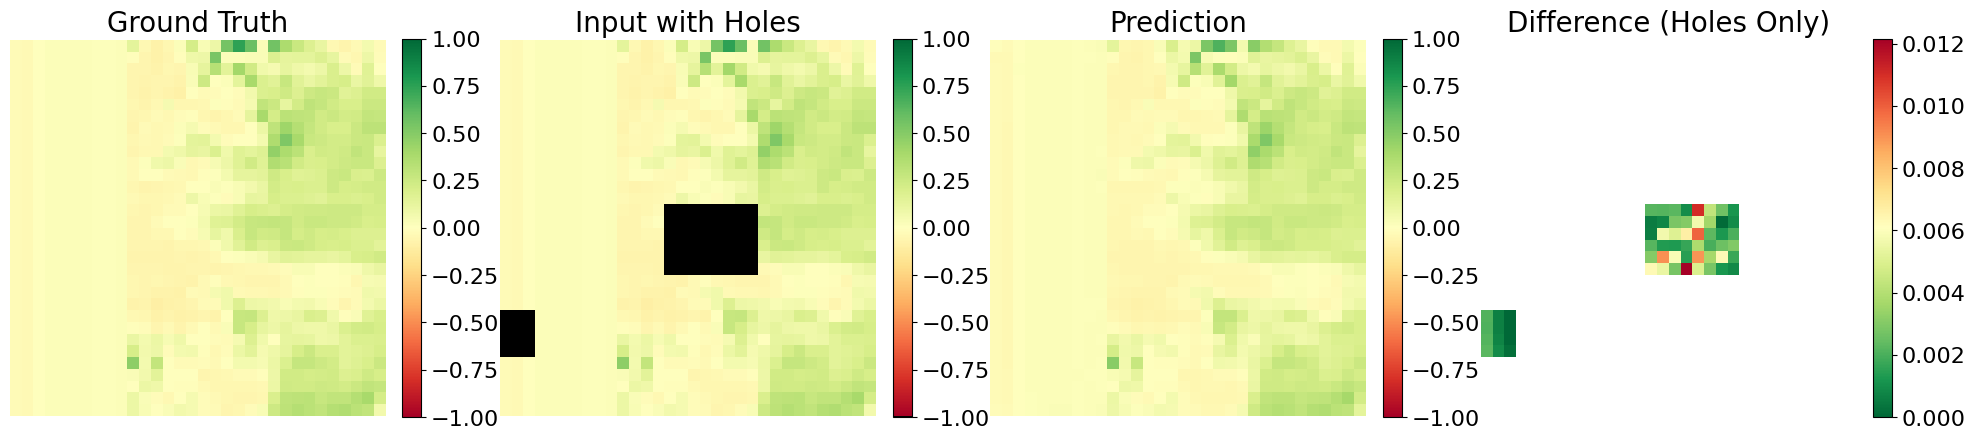

In [57]:
# Création d'une colormap personnalisée pour les trous (valeurs spéciales = 10)
cmap = plt.cm.RdYlGn  # Colormap de base
cmap_colors = cmap(np.linspace(0, 1, 256))
cmap_colors[0] = [0, 0, 0, 1]  # Noir pour les trous (valeurs à 10)
custom_cmap = ListedColormap(cmap_colors)

# Normalisation personnalisée
class CustomNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, special_value=None, **kwargs):
        super().__init__(vmin=vmin, vmax=vmax, **kwargs)
        self.special_value = special_value

    def __call__(self, value, clip=None):
        # Traite les trous comme une valeur spéciale
        result = super().__call__(value, clip)
        result = np.ma.masked_where(value == self.special_value, result)
        result = np.ma.filled(result, 0)  # Mappe les trous (valeurs à 10) sur la première couleur (noir)
        return result

# Appliquer la normalisation personnalisée pour gérer les trous
norm = CustomNormalize(vmin=-1, vmax=1, special_value=10)

# Calcul de la différence entre l'image prédite et l'image originale
difference = np.abs(X_test - y_pred.squeeze())  # Différence absolue

# Créer un masque pour afficher uniquement les trous
mask_holes = (y_test == 10)  # Masque des pixels troués
difference_holes_only = np.where(mask_holes, difference, np.nan)  # Masque les autres pixels

# Visualisation des résultats
idx = 4206  # Index pour visualiser un échantillon spécifique

plt.figure(figsize=(20, 5))

# Vérité terrain
plt.subplot(1, 4, 1)
plt.title("Ground Truth", fontsize=20)  # Increase font size
img1 = plt.imshow(X_test[idx, :, :], cmap='RdYlGn', norm=norm)
plt.axis('off')
cbar1 = plt.colorbar(img1, fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=16)  # Increase colorbar font size

# Image d'entrée avec trous
plt.subplot(1, 4, 2)
plt.title("Input with Holes", fontsize=20)  # Increase font size
img2 = plt.imshow(y_test[idx, :, :], cmap=custom_cmap, norm=norm)
plt.axis('off')
cbar2 = plt.colorbar(img2, fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=16)  # Increase colorbar font size

# Prédictions
plt.subplot(1, 4, 3)
plt.title("Prediction", fontsize=20)  # Increase font size
img3 = plt.imshow(y_pred[idx, :, :], cmap='RdYlGn', norm=norm)
plt.axis('off')
cbar3 = plt.colorbar(img3, fraction=0.046, pad=0.04)
cbar3.ax.tick_params(labelsize=16)  # Increase colorbar font size

# Différence uniquement dans les trous
plt.subplot(1, 4, 4)
plt.title("Difference (Holes Only)", fontsize=20)  # Increase font size
img4 = plt.imshow(difference_holes_only[idx, :, :], cmap='RdYlGn_r', vmin=0)  # Colormap pour différences
plt.axis('off')
cbar4 = plt.colorbar(img4, fraction=0.046, pad=0.04)
cbar4.ax.tick_params(labelsize=16)  # Increase colorbar font size

plt.tight_layout()
plt.show()


#### 3.1 Evaluate the model

In [58]:
# Example: Assuming `MASK_VALUE` is the value used for invalid pixels
MASK_VALUE = 10  # Replace with your actual mask value

# Flatten the arrays to simplify processing (if needed)
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Step 1: Create a mask for valid pixels
valid_mask = y_test_flat != MASK_VALUE

# Step 2: Extract valid pixels from ground truth and predictions
y_test_valid = y_test_flat[valid_mask]
y_pred_valid = y_pred_flat[valid_mask]

# Step 3: Evaluate the model using the valid pixels
# Example: Calculate RMSE
rmse = np.sqrt(np.mean((y_test_valid - y_pred_valid) ** 2))
print(f"RMSE: {rmse}")

# Example: Calculate correlation coefficient (R²)
correlation = np.corrcoef(y_test_valid, y_pred_valid)[0, 1]
r_squared = correlation ** 2
print(f"R²: {r_squared}")



RMSE: 0.009436333552002907
R²: 0.9966429270412092


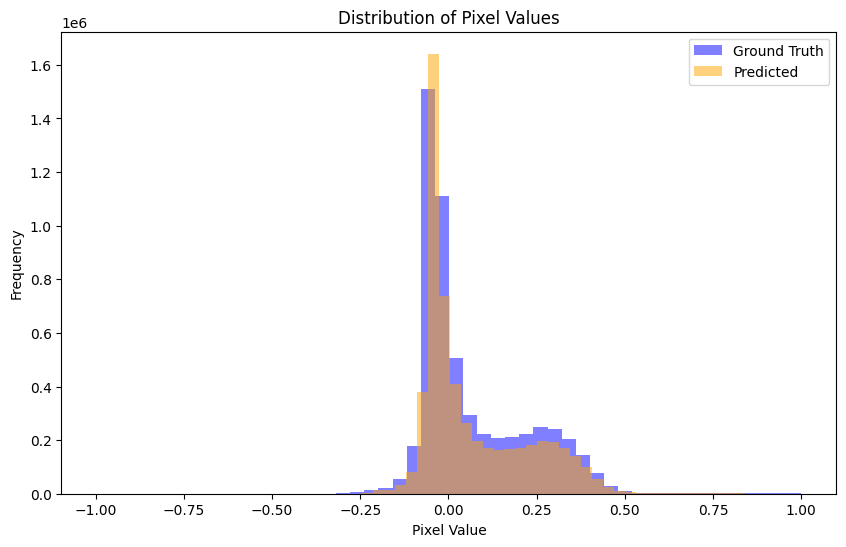

<ipython-input-59-09dce2b95e20>:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test_valid, label='Ground Truth', color='blue', shade=True)
<ipython-input-59-09dce2b95e20>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_valid, label='Predicted', color='orange', shade=True)


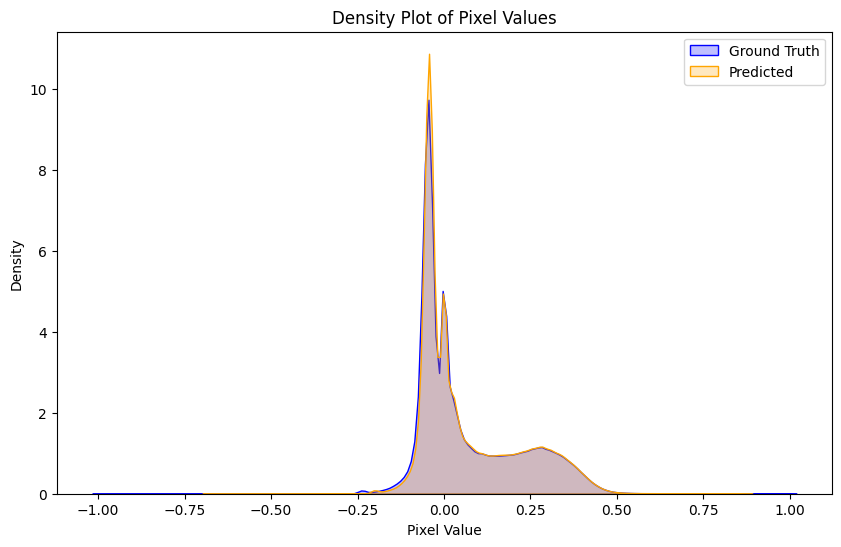

In [59]:
# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(y_test_valid, bins=50, alpha=0.5, label='Ground Truth', color='blue')
plt.hist(y_pred_valid, bins=50, alpha=0.5, label='Predicted', color='orange')
plt.title('Distribution of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Optional: Density plot (smoother)
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test_valid, label='Ground Truth', color='blue', shade=True)
sns.kdeplot(y_pred_valid, label='Predicted', color='orange', shade=True)
plt.title('Density Plot of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.legend()
plt.show()


In [60]:
mae = np.mean(np.abs(y_test_valid - y_pred_valid))
print(f"Mean Absolute Error (MAE): {mae}")
rmse = np.sqrt(np.mean((y_test_valid - y_pred_valid) ** 2))
print(f"Root Mean Square Error (RMSE): {rmse}")
mape = np.mean(np.abs((y_test_valid - y_pred_valid) / y_test_valid)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
correlation = np.corrcoef(y_test_valid, y_pred_valid)[0, 1]
r_squared = correlation ** 2
print(f"R² (Coefficient of Determination): {r_squared}")


Mean Absolute Error (MAE): 0.004869241267442703
Root Mean Square Error (RMSE): 0.009436333552002907
Mean Absolute Percentage Error (MAPE): inf%
R² (Coefficient of Determination): 0.9966429270412092


<ipython-input-60-f0cdbcfc372e>:5: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test_valid - y_pred_valid) / y_test_valid)) * 100


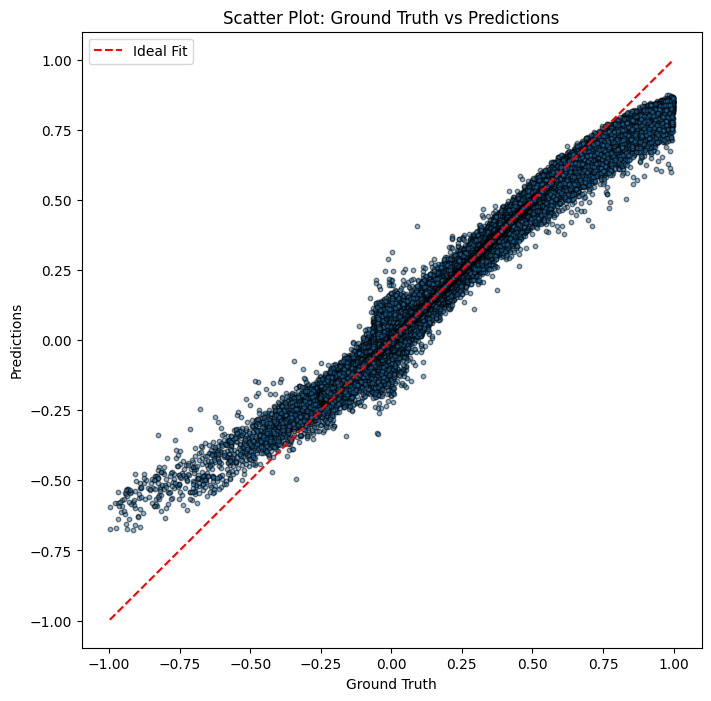

In [61]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test_valid, y_pred_valid, alpha=0.5, edgecolor='k', s=10)
plt.plot([y_test_valid.min(), y_test_valid.max()],
         [y_test_valid.min(), y_test_valid.max()],
         color='red', linestyle='--', label='Ideal Fit')
plt.title('Scatter Plot: Ground Truth vs Predictions')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.legend()
plt.show()


#### 4. Other

In [ ]:
model_path = '/content/drive/My Drive/NDVI_images/best_unet_model_1.keras'
model = load_model(model_path, custom_objects={'masked_mae': masked_mae})

# Print the model architecture
model.summary()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 1)           │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 998,597 (3.81 MB)

 Trainable params: 332,865 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 665,732 (2.54 MB)

In [58]:
# Create the Graphviz object
graph = pydot.Dot(graph_type='digraph', rankdir='LR')  # 'LR' for Left to Right layout

# Define the layers and activations
layers = [
    ("Input", "Input Layer", None),
    ("Conv1", "Conv2D (64 filters, 3x3)", 'relu'),
    ("Conv2", "Conv2D (64 filters, 3x3)", 'relu'),
    ("Pool1", "MaxPooling2D (2x2)", None),
    ("Conv3", "Conv2D (128 filters, 3x3)", 'relu'),
    ("Conv4", "Conv2D (128 filters, 3x3)", 'relu'),
    ("UpSample", "UpSampling2D (2x2)", None),
    ("Conv5", "Conv2D (64 filters, 3x3)", 'relu'),
    ("Output", "Conv2D (1 filter, 1x1)", 'tanh')
]

# Create nodes for the layers
for layer, label, activation in layers:
    label_text = f"{label}\nActivation: {activation}" if activation else label
    graph.add_node(pydot.Node(layer, label=label_text))

# Add edges (connections) between layers
graph.add_edge(pydot.Edge("Input", "Conv1"))
graph.add_edge(pydot.Edge("Conv1", "Conv2"))
graph.add_edge(pydot.Edge("Conv2", "Pool1"))
graph.add_edge(pydot.Edge("Pool1", "Conv3"))
graph.add_edge(pydot.Edge("Conv3", "Conv4"))
graph.add_edge(pydot.Edge("Conv4", "UpSample"))
graph.add_edge(pydot.Edge("UpSample", "Conv5"))
graph.add_edge(pydot.Edge("Conv5", "Output"))

# Create subgraphs to place layers in two columns
# Removed the 'with' statement and directly created the subgraphs
subgraph1 = pydot.Subgraph(rank='same')  # This makes the layers appear on the same level
subgraph1.add_node(pydot.Node("Conv1"))
subgraph1.add_node(pydot.Node("Conv2"))
subgraph1.add_node(pydot.Node("Pool1"))
subgraph1.add_node(pydot.Node("Conv3"))

graph.add_subgraph(subgraph1)

subgraph2 = pydot.Subgraph(rank='same')  # This makes the layers appear on the same level
subgraph2.add_node(pydot.Node("Conv4"))
subgraph2.add_node(pydot.Node("UpSample"))
subgraph2.add_node(pydot.Node("Conv5"))
subgraph2.add_node(pydot.Node("Output"))
graph.add_subgraph(subgraph2)

# Render the diagram
# Set the path to the Graphviz executables
os.environ["PATH"] += os.pathsep + '/usr/bin/dot'

# Use graph.write instead of graph.render
graph.write_png('/content/drive/My Drive/NDVI_images/cnn_with_activations_two_columns.png')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
